# MTSAT-1R/2 HRIT Reader Introduction

## Supported Files

MTSAT-1R JAMI and MTSAT-2 IMAGER data in [JMA HRIT format](https://www.jma.go.jp/jma/jma-eng/satellite/introduction/4_2HRIT.pdf). Both __segmented__ (data split into multiple files) and __non-segmented__ (data in one file) images, as well as __full disk__ and __half disk__ (northern/southern hemisphere) images are supported.

Example filenames:

- Segmented: `IMG_DK01IR1_201006150332_001`
- Non-Segmented: `IMG_DK02IR1_20140524` or `HRIT_MTSAT2_20140524_2201_DK02IR1`

Full disk scans are identified by ``DK01`` , half disk scans by ``DK02/03`` (northern/southern hemisphere). 

Sample data can be found here: https://www.data.jma.go.jp/mscweb/en/operation/sample/hrit.html

## Calibration

You can either read the raw detector counts, or calibrate to Reflectance (VIS channel) or Brightness Temperature (IR channels). Radiance is not supported.

## Examples

The ``SatPy`` reader names are ``jami_hrit`` for JAMI@MTSAT-1R and ``mtsat2-imager_hrit`` for IMAGER@MTSAT-2. The following examples are for MTSAT-2, but you only have to change the reader name to adapt them to MTSAT-1R.

### Mosaic

In [1]:
import glob
import satpy

channels = ['VIS', 'IR4', 'IR3', 'IR1', 'IR2']  # sorted by increasing wavelength

# Create full disk scene of segmented files
filenames = glob.glob('IMG_DK01???_201006150332_???')
scene = satpy.Scene(filenames=filenames, reader='mtsat2-imager_hrit')

# Save quicklook of each channel to file
for ch in channels:
    scene.load([ch])
    scene.save_dataset(ch, filename=ch+'.png')
    del scene[ch]

Then run the following command to create a mosaic from the `.png` files:

    montage VIS.png IR4.png IR3.png IR1.png IR2.png -geometry 256x256 -background black mtsat2_mosaic.jpg

<img src="mtsat2_mosaic.jpg?1">

###  Half Disk Images

Half disk images are supported, too! Information about the covered area are provided in the dataset's area definition:

In [2]:
scene_nh = satpy.Scene(filenames=['HRIT_MTSAT2_20140524_0101_DK02IR1'], reader='mtsat2-imger_hrit')
scene_nh.load(['IR1'], calibration='brightness_temperature')
scene_nh['IR1'].area

Area ID: NH
Description: Northern Hemisphere
Projection ID: geosmsg
Projection: {'a': '6378169.0', 'b': '6356583.8', 'h': '35785831.0', 'lon_0': '145.0', 'proj': 'geos', 'units': 'm'}
Number of columns: 2750
Number of rows: 1375
Area extent: (-5498000.088960204, -198000.00320373234, 5502000.089024927, 5302000.085788833)

Quicklook using cartopy

In [3]:
%matplotlib inline

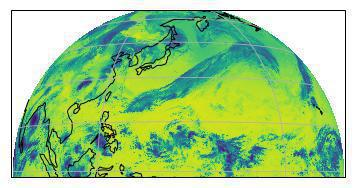

In [4]:
import matplotlib.pyplot as plt

crs = scene_nh['IR1'].area.to_cartopy_crs()
ax = plt.axes(projection=crs)
ax.coastlines()
ax.gridlines()
im = ax.imshow(scene_nh['IR1'], origin='upper', transform=crs, extent=crs.bounds)
plt.show()

Half disk images can easily be resampled to the full disk:

/cmsaf/nfshome/routcm/Modules_CentOS/python/2.7.14/lib/python2.7/site-packages/cartopy/mpl/feature_artist.py:136: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


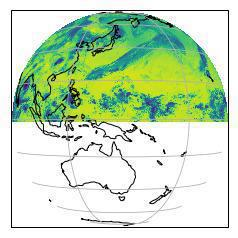

In [5]:
import pyresample.geometry
import matplotlib.pyplot as plt

full_disk = pyresample.geometry.AreaDefinition(
    area_id='FLDK',
    name='Full Disk',
    proj_id='geosmsg',
    proj_dict={'a': '6378169.0', 
               'b': '6356583.8', 
               'h': '35785831.0', 
               'lon_0': '145.0', 
               'proj': 'geos',
               'units': 'm'},
    y_size=2750, x_size=2750,
    area_extent=(-5498000.088960204, -5498000.088960204, 
                 5502000.089024927, 5502000.089024927)
)  # copied from a full disk scene

# Resample to full disk
resampled = scene_nh.resample(full_disk)

# Plot
crs = full_disk.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw=dict(projection=crs))
ax.gridlines()
ax.coastlines()
im = ax.imshow(resampled['IR1'], origin='upper', transform=crs, extent=crs.bounds)
plt.show()